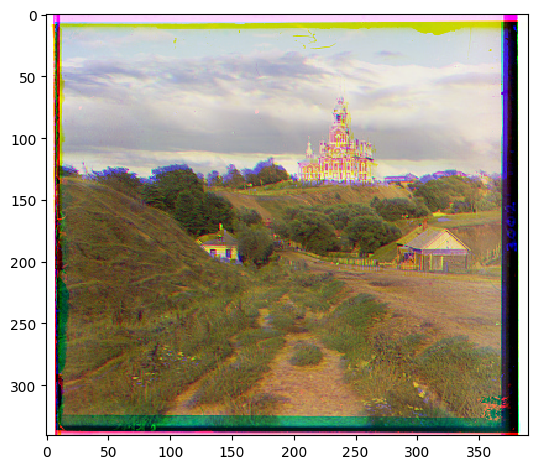

In [7]:
import numpy as np
import skimage as sk
import skimage.io as skio

def align(img1, img2, max_shift=15):
    """Align img2 to img1 using an exhaustive search over a specified range."""
    best_score = float('inf')
    best_shift = (0, 0)
    
    for x_shift in range(-max_shift, max_shift+1):
        for y_shift in range(-max_shift, max_shift+1):
            shifted_img2 = np.roll(np.roll(img2, x_shift, axis=1), y_shift, axis=0)
            score = np.sum((img1 - shifted_img2) ** 2)  # L2 norm
            
            if score < best_score:
                best_score = score
                best_shift = (x_shift, y_shift)
    
    return np.roll(np.roll(img2, best_shift[0], axis=1), best_shift[1], axis=0), best_shift

# Example usage
imname = 'Input/cathedral.jpg'
im = skio.imread(imname)
im = sk.img_as_float(im)

height = np.floor(im.shape[0] / 3.0).astype(int)

b = im[:height]
g = im[height:2*height]
r = im[2*height:3*height]

ag, g_shift = align(b, g)
ar, r_shift = align(b, r)

im_out = np.dstack([ar, ag, b])

# save the image
im_out_uint8 = sk.img_as_ubyte(im_out)
fname = 'Result/out_fname.jpg'
skio.imsave(fname, im_out_uint8)

# display the image
skio.imshow(im_out)
skio.show()

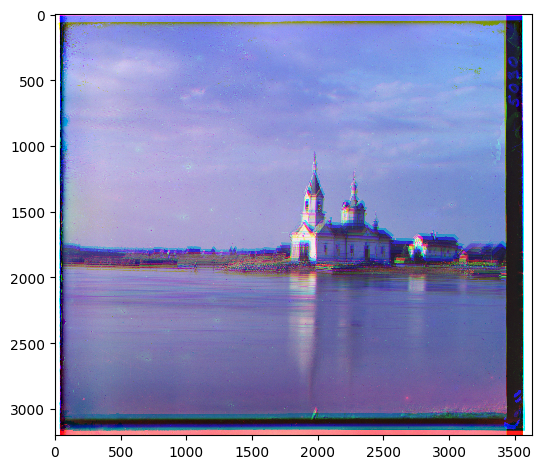

In [10]:
import skimage.transform as sktr

def align(img1, img2, max_shift=15):
    """Align img2 to img1 using an exhaustive search over a specified range."""
    best_score = float('inf')
    best_shift = (0, 0)
    
    for x_shift in range(-max_shift, max_shift+1):
        for y_shift in range(-max_shift, max_shift+1):
            shifted_img2 = np.roll(np.roll(img2, x_shift, axis=1), y_shift, axis=0)
            score = np.sum((img1 - shifted_img2) ** 2)  # L2 norm
            
            if score < best_score:
                best_score = score
                best_shift = (x_shift, y_shift)
    
    return np.roll(np.roll(img2, best_shift[0], axis=1), best_shift[1], axis=0), best_shift

def pyramid_align(img1, img2, max_shift=15, num_levels=4):
    """Align img2 to img1 using a multi-resolution pyramid approach."""
    if num_levels == 0:
        return align(img1, img2, max_shift)
    
    # Reduce image size to create the next level of the pyramid
    img1_small = sktr.rescale(img1, 0.5, anti_aliasing=True)
    img2_small = sktr.rescale(img2, 0.5, anti_aliasing=True)
    
    # Align at the next level of the pyramid
    aligned_img2_small, shift_small = pyramid_align(img1_small, img2_small, max_shift, num_levels-1)
    
    # Upscale the alignment shift to the current level
    shift_large = (shift_small[0] * 2, shift_small[1] * 2)
    aligned_img2 = np.roll(np.roll(img2, shift_large[0], axis=1), shift_large[1], axis=0)
    
    # Fine-tune alignment at the current level
    return align(img1, aligned_img2, max_shift)


In [12]:
import numpy as np
import skimage.io as skio
import skimage.transform as sktr

def vectorized_align(img1, img2, max_shift=15):
    """Vectorized alignment of img2 to img1."""
    shifts = range(-max_shift, max_shift + 1)
    best_score = float('inf')
    best_shift = (0, 0)
    
    for x_shift in shifts:
        shifted_img2 = np.roll(img2, x_shift, axis=1)
        # Vectorized y_shift computation
        y_scores = [(np.sum((img1 - np.roll(shifted_img2, y_shift, axis=0)) ** 2), y_shift)
                    for y_shift in shifts]
        min_y_score, best_y_shift = min(y_scores, key=lambda x: x[0])
        
        if min_y_score < best_score:
            best_score = min_y_score
            best_shift = (x_shift, best_y_shift)
    
    aligned_img2 = np.roll(np.roll(img2, best_shift[0], axis=1), best_shift[1], axis=0)
    return aligned_img2, best_shift

# Apply pyramid alignment with vectorized function
def vectorized_pyramid_align(img1, img2, max_shift=15, num_levels=4):
    """Align img2 to img1 using a multi-resolution pyramid approach with vectorized code."""
    if num_levels == 0:
        return vectorized_align(img1, img2, max_shift)
    
    # Reduce image size to create the next level of the pyramid
    img1_small = sktr.rescale(img1, 0.5, anti_aliasing=True)
    img2_small = sktr.rescale(img2, 0.5, anti_aliasing=True)
    
    # Align at the next level of the pyramid
    aligned_img2_small, shift_small = vectorized_pyramid_align(img1_small, img2_small, max_shift, num_levels-1)
    
    # Upscale the alignment shift to the current level
    shift_large = (shift_small[0] * 2, shift_small[1] * 2)
    aligned_img2 = np.roll(np.roll(img2, shift_large[0], axis=1), shift_large[1], axis=0)
    
    # Fine-tune alignment at the current level
    return vectorized_align(img1, aligned_img2, max_shift)


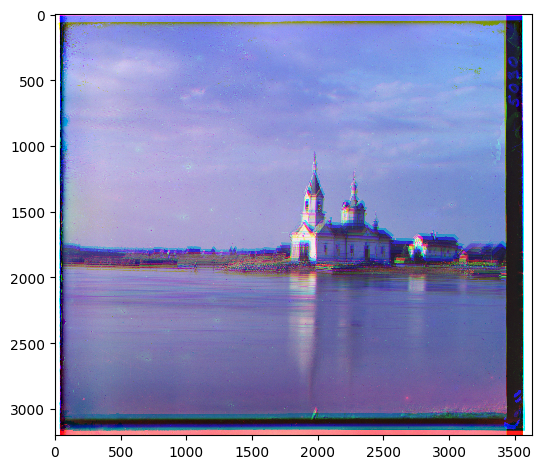

In [13]:
# Example usage with a .tif file
imname = 'Input/church.tif'
im = skio.imread(imname)
im = sk.img_as_float(im)

height = np.floor(im.shape[0] / 3.0).astype(int)

b = im[:height]
g = im[height:2*height]
r = im[2*height:3*height]

# Apply pyramid alignment
ag, g_shift = pyramid_align(b, g)
ar, r_shift = pyramid_align(b, r)

im_out = np.dstack([ar, ag, b])

# save the image
im_out_uint8 = sk.img_as_ubyte(im_out)
skio.imsave('Result/output_church.jpg', im_out_uint8)

# display the image
skio.imshow(im_out)
skio.show()
